# **Processamento Digital de Imagens - 2023.2**
# Implementação de um codificador de imagem simples


- Equipe:
  - Emanoel Cristhian Leão Marinho (201806840098)
  - Frank Bruno Ferreira Boa Morte (202006840007)
  - Mercedes Maria Barbosa Diniz (201906840030)

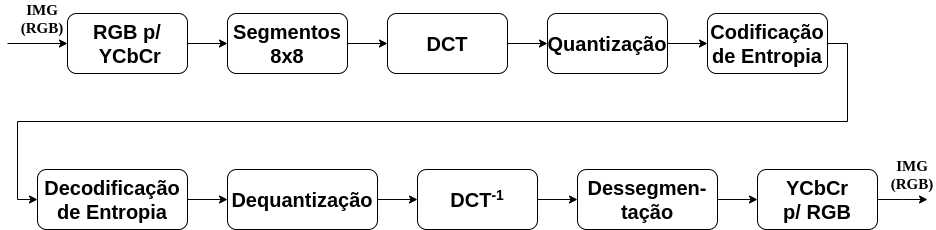

## Bibliotecas

In [ ]:
# Bibliotecas:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
import scipy
from skimage.util import view_as_blocks
from scipy.fftpack import idct

## Importando a Imagem de teste

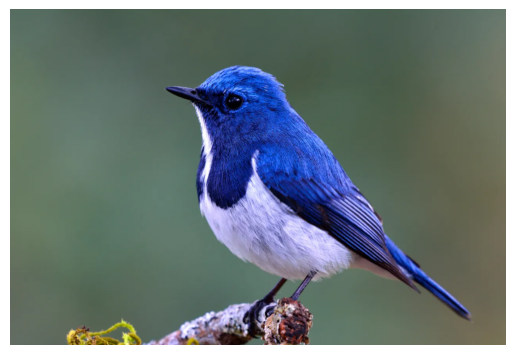

In [ ]:
nome = 'passaro_azul.bmp' # nome da imagem
img_original = cv2.imread(nome) # formato BGR (padrão utilizado pelo OpenCV)

# converte a imagem do formato BGR p/ o RGB
img_original_rgb = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)

# Exibindo a imagem
plt.imshow(img_original_rgb)
plt.axis('off')
plt.show()

## PSNR (Peak Signal-to-Noise Ratio)

Métrica comumente usada para medir a qualidade de uma imagem comprimida ou reconstruída em relação a uma imagem original de referência. Ele calcula a relação sinal-ruído entre as duas imagens, levando em consideração o erro quadrático médio (MSE) entre os pixels das imagens. Quanto maior o valor do PSNR, menor é a diferença perceptual entre as imagens e, portanto, maior é a qualidade da imagem reconstruída.

Formula:

$ PSNR = 10\times log_{10}(\frac{MAX^{2}}{MSE})$

onde:
- $MAX$: o valor máximo que um pixel pode ter na imagem
- $MSE$: o erro médio quadrático entre as duas imagens


In [ ]:
def calculaPSNR(img1, img2):
    # Verificando se as imagens têm o mesmo tamanho
    if img1.shape != img2.shape:
        raise ValueError("As imagens devem ter o mesmo tamanho.")

    # Convertendo as imagens para o tipo float32
    img1 = img1.astype(np.float32)
    img2 = img2.astype(np.float32)

    # Calculando o erro quadrático médio (MSE)
    mse = np.mean((img1 - img2) ** 2)

    # Verificando se o MSE é zero
    if mse == 0:
        return float('inf')  # PSNR é infinito quando MSE é zero

    # Calculando o PSNR
    max_pixel = 255.0
    psnr = 10 * np.log10((max_pixel**2)/mse) # em dB

    return psnr

## **Implementação dos Modulos de Codificação e Decodificação**

### Conversão de mapa de cor

In [ ]:
def RGB_to_YCrCb(img):
    # Conversão RGB para YCrCb
    img_YCrCb = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    return img_YCrCb

def subSampling(img, theta):
    # Separando as componentes:
    Y, Cr, Cb = cv2.split(img)

    # Sub-amostragem
    if theta == '4:4:4':
        return Y, Cr, Cb
    elif theta == '4:2:2':
        # Elimina as colunas pares das componentes Cb e Cr
        Cr_subsampled = Cr[:, ::2].copy()
        Cb_subsampled = Cb[:, ::2].copy()
        return Y, Cr_subsampled, Cb_subsampled

    elif theta == '4:2:0':
        # Elimina as colunas e as linhas pares das componentes Cb e Cr
        Cr_subsampled = Cr[::2, ::2].copy()
        Cb_subsampled = Cb[::2, ::2].copy()
        return Y, Cr_subsampled, Cb_subsampled
    else:
        raise ValueError("Theta deve ser '4:4:4', '4:2:2' ou '4:2:0'.")

In [ ]:
def upSampling(Y, Cr, Cb, theta):
    # Super-amostragem
    if theta == '4:4:4':
        return Y, Cr, Cb
    elif theta == '4:2:2':
        # Duplicar as colunas eliminadas com interpolação bilinear
        Cr_upsampled = cv2.resize(Cr, None, fx=2, fy=1, interpolation=0)
        Cb_upsampled = cv2.resize(Cb, None, fx=2, fy=1, interpolation=0)
        return Y, Cr_upsampled, Cb_upsampled
    elif theta == '4:2:0':
        # Duplicar as colunas e linhas eliminadas com interpolação bilinear
        Cr_upsampled = cv2.resize(Cr, None, fx=2, fy=2, interpolation=0)
        Cb_upsampled = cv2.resize(Cb, None, fx=2, fy=2, interpolation=0)
        return Y, Cr_upsampled, Cb_upsampled
    else:
        raise ValueError("Theta deve ser '4:4:4', '4:2:2' ou '4:2:0'.")

def YCrCb_to_RGB(img):
    # Conversão YCrCb para RGB
    img_RGB = cv2.cvtColor(img, cv2.COLOR_YCrCb2RGB)
    return img_RGB

#def upSampling(Y, Cr, Cb, theta):
#    # Super-amostragem
#    if theta == '4:4:4':
#        return Y, Cr, Cb
#    elif theta == '4:2:2':
#        # Duplicar as colunas eliminadas com interpolação bilinear
#        Cr_upsampled = cv2.resize(Cr, (Y.shape[1], Y.shape[0]), interpolation=cv2.INTER_LINEAR).copy()
#        Cb_upsampled = cv2.resize(Cb, (Y.shape[1], Y.shape[0]), interpolation=cv2.INTER_LINEAR).copy()
#        return Y, Cr_upsampled, Cb_upsampled
#    elif theta == '4:2:0':
#        # Duplicar as colunas e linhas eliminadas com interpolação bilinear
#        Cr_upsampled = cv2.resize(Cr, (Y.shape[1], Y.shape[0]), interpolation=cv2.INTER_LINEAR).copy()
#        Cb_upsampled = cv2.resize(Cb, (Y.shape[1], Y.shape[0]), interpolation=cv2.INTER_LINEAR).copy()
#        return Y, Cr_upsampled, Cb_upsampled
#    else:
#        raise ValueError("Theta deve ser '4:4:4', '4:2:2' ou '4:2:0'.")

### Segmentação e DCT

In [ ]:
# Funções de redimencionamento de matriz
def redimensionar_matriz_para_segmentacao(matriz):
    altura, largura = matriz.shape

    # Verificar se a altura e a largura são múltiplas de 8
    if altura % 8 == 0 and largura % 8 == 0:
        # A matriz já possui dimensões múltiplas de 8, não há necessidade de redimensionamento
        return matriz,altura,largura

    # Calcular as novas dimensões múltiplas de 8
    nova_altura = altura + (8 - altura % 8)
    nova_largura = largura + (8 - largura % 8)

    # Criar uma nova matriz com as novas dimensões
    nova_matriz = np.zeros((nova_altura, nova_largura), dtype=np.float32)

    # Copiar os valores da matriz original para a nova matriz
    nova_matriz[:altura, :largura] = matriz
    nova_altura,nova_largura = nova_matriz.shape

    return nova_matriz,nova_altura,nova_largura

def desfazer_redimensionamento_da_segmentacao(matriz, altura_original, largura_original):
    altura_redimensionada, largura_redimensionada = matriz.shape

    if altura_redimensionada == altura_original and largura_redimensionada == largura_original:
        return matriz
    else:
        matriz_desfeita = matriz[:altura_original, :largura_original]
        return matriz_desfeita

def redimensionar_matriz_para_o_tamanho_original(matriz, tamanho_original):
    altura_original, largura_original = tamanho_original
    altura_redimensionada, largura_redimensionada = matriz.shape[:2]
    if altura_redimensionada == altura_original and largura_redimensionada == largura_original:
        return matriz
    else:
        matriz_redimensionada = cv2.resize(matriz, (largura_original, altura_original))
        return matriz_redimensionada

In [ ]:
def segmentacao_8x8(componente):
    componente_redimensionada, altura_redimensionada, largura_redimensionada = redimensionar_matriz_para_segmentacao(componente)
    blocos = view_as_blocks(componente_redimensionada, block_shape=(8, 8))

    # Achatando os blocos para uma lista de blocos
    blocos_achatados = blocos.reshape((-1, 8, 8))

    return blocos_achatados, altura_redimensionada, largura_redimensionada

In [ ]:
def calcula_dct(blocos):
    # Inicializar a matriz resultante com zeros
    #matriz_resultante = np.zeros((altura,largura), dtype=np.float32)
    # Iterar sobre cada bloco
    dct_blocos = []
    for i, bloco in enumerate(blocos):
        bloco -= 128
        # Aplicar a DCT no bloco
        dct_blocos.append(cv2.dct(bloco.astype(np.float32)))

        # Juntar o bloco na matriz resultante
        # linha = i // (largura // 8)
        # coluna = i % (largura // 8)
        # matriz_resultante[linha*8:(linha+1)*8, coluna*8:(coluna+1)*8] = dct_bloco

    return dct_blocos

In [ ]:
def calcula_dct_inversa(blocos,altura,largura):
    # Inicializar a matriz resultante com zeros
    matriz_resultante = np.zeros((altura,largura), dtype=np.uint8)
    # Iterar sobre cada bloco
    for i, bloco in enumerate(blocos):
        #bloco += 128
        # Aplicar a DCT no bloco
        dct_bloco = cv2.idct(bloco)
        dct_bloco = dct_bloco+128
        # Alterar cada valor de 'c' no bloco
        for l in range(len(dct_bloco)):
          for c in range(len(dct_bloco[l])):
            if dct_bloco[l][c] > 255:
              dct_bloco[l][c] = 255
            elif dct_bloco[l][c] < 0:
              dct_bloco[l][c] = 0

        # Juntar o bloco na matriz resultante
        linha = i // (largura // 8)
        coluna = i % (largura // 8)
        matriz_resultante[linha*8:(linha+1)*8, coluna*8:(coluna+1)*8] = dct_bloco.astype(np.uint8)
        #matriz_resultante.astype(np.uint8)
    return matriz_resultante

def retornar_tamanho_matriz(matriz, altura, largura):
    # Obtém as dimensões da matriz original
    altura_original, largura_original = matriz.shape

    # Verifica se os valores de altura e largura estão dentro dos limites da matriz original
    if altura > altura_original or largura > largura_original:
        raise ValueError("Os valores de altura e largura fornecidos são maiores do que as dimensões da matriz original.")

    # Redimensiona a matriz original para conter apenas os valores da altura e largura fornecidas
    matriz_redimensionada = matriz[:altura, :largura]

    return matriz_redimensionada

In [ ]:
def plot_segmentos(segmentos, num_segmentos):
    for i in range(num_segmentos):
        segmento = segmentos[i]
        print(f"Segmento {i+1}:")
        print(segmento)
        print("\n")

### Quantização

In [ ]:
tabela_lum = 1*np.array(
    [[16, 11, 10, 16, 124, 140, 151, 161],
    [12, 12, 14, 19, 126, 158, 160, 155],
    [14, 13, 16, 24, 140, 157, 169, 156],
    [14, 17, 22, 29, 151, 187, 180, 162],
    [18, 22, 37, 56, 168, 109, 103, 177],
    [24, 35, 55, 64, 181, 104, 113, 192],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]])
tabela_crom = 1*np.array(
    [[17, 18, 24, 47, 99, 99, 99, 99],
    [18, 21, 26, 66, 99, 99, 99, 99],
    [24, 26, 56, 99, 99, 99, 99, 99],
    [47, 66, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99]])

In [ ]:
def quantizacao(lista_blocos,tabela,modo=str):
    if(modo == "quantiza"):
        blocos_quantizado = []
        for bloco in lista_blocos:
            # Realizar a divisão de cada elemento
            resultado_divisao = (bloco/tabela)
            # Arredondar cada elemento para o número inteiro mais próximo
            blocos_quantizado.append(np.round(resultado_divisao).astype(np.float32))
        return blocos_quantizado
    elif(modo == "dequantiza"):
        blocos_dequantizados = []
        for bloco in lista_blocos:
          # Realizar a multiplixação de cada elemento
          resultado_mult = np.multiply(bloco,tabela)
          # adiciona o resultado da multiplicação
          blocos_dequantizados.append(resultado_mult.astype(np.float32))
        return blocos_dequantizados

### Tabelas de Codificação JPEG

In [ ]:

categorias_componentes_DC = {
    '0': {'Categoria': 0, 'Range': (0, 0)},
    '1': {'Categoria': 1, 'Range': (1, 1)},
    '2': {'Categoria': 2, 'Range': (2, 3)},
    '3': {'Categoria': 3, 'Range': (4, 7)},
    '4': {'Categoria': 4, 'Range': (8, 15)},
    '5': {'Categoria': 5, 'Range': (16, 31)},
    '6': {'Categoria': 6, 'Range': (32, 63)},
    '7': {'Categoria': 7, 'Range': (64, 127)},
    '8': {'Categoria': 8, 'Range': (128, 255)},
    '9': {'Categoria': 9, 'Range': (256, 511)},
    'A': {'Categoria': 10, 'Range': (512, 1023)},
    'B': {'Categoria': 11, 'Range': (1024, 2047)},
    'C': {'Categoria': 12, 'Range': (2048, 4095)},
    'D': {'Categoria': 13, 'Range': (4096, 8191)},
    'E': {'Categoria': 14, 'Range': (8192, 16383)},
    'F': {'Categoria': 15, 'Range': (16384, 32767)}
}

categorias_componentes_AC = {
    '1':{'Categoria': 1, 'Range': (1, 1)},
    '2':{'Categoria': 2, 'Range': (2, 3)},
    '3':{'Categoria': 3, 'Range': (4, 7)},
    '4':{'Categoria': 4, 'Range': (8, 15)},
    '5':{'Categoria': 5, 'Range': (16, 31)},
    '6':{'Categoria': 6, 'Range': (32, 63)},
    '7':{'Categoria': 7, 'Range': (64, 127)},
    '8':{'Categoria': 8, 'Range': (128, 255)},
    '9':{'Categoria': 9, 'Range': (256, 511)},
    'A': {'Categoria': 10, 'Range': (512, 1023)},
    'B': {'Categoria': 11, 'Range': (1024, 2047)},
    'C': {'Categoria': 12, 'Range': (2048, 4095)},
    'D': {'Categoria': 13, 'Range': (4096, 8191)},
    'E': {'Categoria': 14, 'Range': (8192, 16383)}
}

base_code_DC = {
    '0': {'Categoria': 0, 'Base Code': '010', 'Length': 3},
    '1': {'Categoria': 1, 'Base Code': '011', 'Length': 4},
    '2': {'Categoria': 2, 'Base Code': '100', 'Length': 5},
    '3': {'Categoria': 3, 'Base Code': '00', 'Length': 5},
    '4': {'Categoria': 4, 'Base Code': '101', 'Length': 7},
    '5': {'Categoria': 5, 'Base Code': '110', 'Length': 8},
    '6': {'Categoria': 6, 'Base Code': '1110', 'Length': 10},
    '7': {'Categoria': 7, 'Base Code': '111110', 'Length': 12},
    '8': {'Categoria': 8, 'Base Code': '1111110', 'Length': 14},
    '9': {'Categoria': 9, 'Base Code': '11111110', 'Length': 16},
    'A': {'Categoria': 10, 'Base Code': '111111110', 'Length': 18},
    'B': {'Categoria': 11, 'Base Code': '1111111110', 'Length': 20}
}
base_code_AC = {
    '0/0': {'Categoria': 0, 'Qtd_Zeros': 0, 'Base Code': '1010', 'Length': 4},
    '0/1': {'Categoria': 1, 'Qtd_Zeros': 0, 'Base Code': '00', 'Length': 3},
    '0/2': {'Categoria': 2, 'Qtd_Zeros': 0, 'Base Code': '01', 'Length': 4},
    '0/3': {'Categoria': 3, 'Qtd_Zeros': 0, 'Base Code': '100', 'Length': 6},
    '0/4': {'Categoria': 4, 'Qtd_Zeros': 0, 'Base Code': '1011', 'Length': 8},
    '0/5': {'Categoria': 5, 'Qtd_Zeros': 0, 'Base Code': '11010', 'Length': 10},
    '0/6': {'Categoria': 6, 'Qtd_Zeros': 0, 'Base Code': '111000', 'Length': 12},
    '0/7': {'Categoria': 7, 'Qtd_Zeros': 0, 'Base Code': '1111000', 'Length': 14},
    '0/8': {'Categoria': 8, 'Qtd_Zeros': 0, 'Base Code': '1111110110', 'Length': 18},
    '0/9': {'Categoria': 9, 'Qtd_Zeros': 0, 'Base Code': '1111111110000010', 'Length': 25},
    '0/A': {'Categoria': 10, 'Qtd_Zeros': 0, 'Base Code': '1111111110000011', 'Length': 26},
    '1/1': {'Categoria': 1, 'Qtd_Zeros': 1, 'Base Code': '1100', 'Length': 5},
    '1/2': {'Categoria': 2, 'Qtd_Zeros': 1, 'Base Code': '111001', 'Length': 8},
    '1/3': {'Categoria': 3, 'Qtd_Zeros': 1, 'Base Code': '1111001', 'Length': 10},
    '1/4': {'Categoria': 4, 'Qtd_Zeros': 1, 'Base Code': '111110110', 'Length': 13},
    '1/5': {'Categoria': 5, 'Qtd_Zeros': 1, 'Base Code': '11111110110', 'Length': 16},
    '1/6': {'Categoria': 6, 'Qtd_Zeros': 1, 'Base Code': '1111111110000100', 'Length': 22},
    '1/7': {'Categoria': 7, 'Qtd_Zeros': 1, 'Base Code': '1111111110000101', 'Length': 23},
    '1/8': {'Categoria': 8, 'Qtd_Zeros': 1, 'Base Code': '1111111110000110', 'Length': 24},
    '1/9': {'Categoria': 9, 'Qtd_Zeros': 1, 'Base Code': '1111111110000111', 'Length': 25},
    '1/A': {'Categoria': 10, 'Qtd_Zeros': 1, 'Base Code': '1111111110001000', 'Length': 26},
    '2/1': {'Categoria': 1, 'Qtd_Zeros': 2, 'Base Code': '11011', 'Length': 6},
    '2/2': {'Categoria': 2, 'Qtd_Zeros': 2, 'Base Code': '11111000', 'Length': 10},
    '2/3': {'Categoria': 3, 'Qtd_Zeros': 2, 'Base Code': '1111110111', 'Length': 13},
    '2/4': {'Categoria': 4, 'Qtd_Zeros': 2, 'Base Code': '1111111110001001', 'Length': 20},
    '2/5': {'Categoria': 5, 'Qtd_Zeros': 2, 'Base Code': '1111111110001010', 'Length': 21},
    '2/6': {'Categoria': 6, 'Qtd_Zeros': 2, 'Base Code': '1111111110001011', 'Length': 22},
    '2/7': {'Categoria': 7, 'Qtd_Zeros': 2, 'Base Code': '1111111110001100', 'Length': 23},
    '2/8': {'Categoria': 8, 'Qtd_Zeros': 2, 'Base Code': '1111111110001101', 'Length': 24},
    '2/9': {'Categoria': 9, 'Qtd_Zeros': 2, 'Base Code': '1111111110001110', 'Length': 25},
    '2/A': {'Categoria': 10, 'Qtd_Zeros': 2, 'Base Code': '1111111110001111', 'Length': 26},
    '3/1': {'Categoria': 1, 'Qtd_Zeros': 3, 'Base Code': '111010', 'Length': 7},
    '3/2': {'Categoria': 2, 'Qtd_Zeros': 3, 'Base Code': '111110111', 'Length': 11},
    '3/3': {'Categoria': 3, 'Qtd_Zeros': 3, 'Base Code': '11111110111', 'Length': 14},
    '3/4': {'Categoria': 4, 'Qtd_Zeros': 3, 'Base Code': '1111111110010000', 'Length': 20},
    '3/5': {'Categoria': 5, 'Qtd_Zeros': 3, 'Base Code': '1111111110010001', 'Length': 21},
    '3/6': {'Categoria': 6, 'Qtd_Zeros': 3, 'Base Code': '1111111110010010', 'Length': 22},
    '3/7': {'Categoria': 7, 'Qtd_Zeros': 3, 'Base Code': '1111111110010011', 'Length': 23},
    '3/8': {'Categoria': 8, 'Qtd_Zeros': 3, 'Base Code': '1111111110010100', 'Length': 24},
    '3/9': {'Categoria': 9, 'Qtd_Zeros': 3, 'Base Code': '1111111110010101', 'Length': 25},
    '3/A': {'Categoria': 10, 'Qtd_Zeros': 3, 'Base Code': '1111111110010110', 'Length': 26},
    '4/1': {'Categoria': 1, 'Qtd_Zeros': 4, 'Base Code': '111011', 'Length': 7},
    '4/2': {'Categoria': 2, 'Qtd_Zeros': 4, 'Base Code': '1111111000', 'Length': 11},
    '4/3': {'Categoria': 3, 'Qtd_Zeros': 4, 'Base Code': '1111111110010111', 'Length': 18},
    '4/4': {'Categoria': 4, 'Qtd_Zeros': 4, 'Base Code': '1111111110011000', 'Length': 18},
    '4/5': {'Categoria': 5, 'Qtd_Zeros': 4, 'Base Code': '1111111110011001', 'Length': 19},
    '4/6': {'Categoria': 6, 'Qtd_Zeros': 4, 'Base Code': '1111111110011010', 'Length': 20},
    '4/7': {'Categoria': 7, 'Qtd_Zeros': 4, 'Base Code': '1111111110011011', 'Length': 21},
    '4/8': {'Categoria': 8, 'Qtd_Zeros': 4, 'Base Code': '1111111110011100', 'Length': 22},
    '4/9': {'Categoria': 9, 'Qtd_Zeros': 4, 'Base Code': '1111111110011101', 'Length': 23},
    '4/A': {'Categoria': 10, 'Qtd_Zeros': 4, 'Base Code': '1111111110011110', 'Length': 24},
    '5/1': {'Categoria': 1, 'Qtd_Zeros': 5, 'Base Code': '1111000', 'Length': 7},
    '5/2': {'Categoria': 2, 'Qtd_Zeros': 5, 'Base Code': '1111111110011111', 'Length': 15},
    '5/3': {'Categoria': 3, 'Qtd_Zeros': 5, 'Base Code': '1111111110100000', 'Length': 15},
    '5/4': {'Categoria': 4, 'Qtd_Zeros': 5, 'Base Code': '1111111110100001', 'Length': 16},
    '5/5': {'Categoria': 5, 'Qtd_Zeros': 5, 'Base Code': '1111111110100010', 'Length': 17},
    '5/6': {'Categoria': 6, 'Qtd_Zeros': 5, 'Base Code': '1111111110100011', 'Length': 18},
    '5/7': {'Categoria': 7, 'Qtd_Zeros': 5, 'Base Code': '1111111110100100', 'Length': 19},
    '5/8': {'Categoria': 8, 'Qtd_Zeros': 5, 'Base Code': '1111111110100101', 'Length': 20},
    '5/9': {'Categoria': 9, 'Qtd_Zeros': 5, 'Base Code': '1111111110100110', 'Length': 21},
    '5/A': {'Categoria': 10, 'Qtd_Zeros': 5, 'Base Code': '1111111110100111', 'Length': 22},
    '6/1': {'Categoria': 1, 'Qtd_Zeros': 6, 'Base Code': '1111010', 'Length': 7},
    '6/2': {'Categoria': 2, 'Qtd_Zeros': 6, 'Base Code': '1111111110101000', 'Length': 18},
    '6/3': {'Categoria': 3, 'Qtd_Zeros': 6, 'Base Code': '1111111110101001', 'Length': 19},
    '6/4': {'Categoria': 4, 'Qtd_Zeros': 6, 'Base Code': '1111111110101010', 'Length': 20},
    '6/5': {'Categoria': 5, 'Qtd_Zeros': 6, 'Base Code': '1111111110101011', 'Length': 21},
    '6/6': {'Categoria': 6, 'Qtd_Zeros': 6, 'Base Code': '1111111110101100', 'Length': 22},
    '6/7': {'Categoria': 7, 'Qtd_Zeros': 6, 'Base Code': '1111111110101101', 'Length': 23},
    '6/8': {'Categoria': 8, 'Qtd_Zeros': 6, 'Base Code': '1111111110101110', 'Length': 24},
    '6/9': {'Categoria': 9, 'Qtd_Zeros': 6, 'Base Code': '1111111110101111', 'Length': 25},
    '6/A': {'Categoria': 10, 'Qtd_Zeros': 6, 'Base Code': '1111111110110000', 'Length': 26},
    '7/1': {'Categoria': 1, 'Qtd_Zeros': 7, 'Base Code': '11111010', 'Length': 8},
    '7/2': {'Categoria': 2, 'Qtd_Zeros': 7, 'Base Code': '1111111110110001', 'Length': 18},
    '7/3': {'Categoria': 3, 'Qtd_Zeros': 7, 'Base Code': '1111111110110010', 'Length': 19},
    '7/4': {'Categoria': 4, 'Qtd_Zeros': 7, 'Base Code': '1111111110110011', 'Length': 20},
    '7/5': {'Categoria': 5, 'Qtd_Zeros': 7, 'Base Code': '1111111110110100', 'Length': 21},
    '7/6': {'Categoria': 6, 'Qtd_Zeros': 7, 'Base Code': '1111111110110101', 'Length': 22},
    '7/7': {'Categoria': 7, 'Qtd_Zeros': 7, 'Base Code': '1111111110110110', 'Length': 23},
    '7/8': {'Categoria': 8, 'Qtd_Zeros': 7, 'Base Code': '1111111110110111', 'Length': 24},
    '7/9': {'Categoria': 9, 'Qtd_Zeros': 7, 'Base Code': '1111111110111000', 'Length': 25},
    '7/A': {'Categoria': 10, 'Qtd_Zeros': 7, 'Base Code': '1111111110111001', 'Length': 26},
    '8/1': {'Categoria': 1, 'Qtd_Zeros': 8, 'Base Code': '111111000', 'Length': 9},
    '8/2': {'Categoria': 2, 'Qtd_Zeros': 8, 'Base Code': '1111111110111010', 'Length': 19},
    '8/3': {'Categoria': 3, 'Qtd_Zeros': 8, 'Base Code': '1111111110111011', 'Length': 20},
    '8/4': {'Categoria': 4, 'Qtd_Zeros': 8, 'Base Code': '1111111110111100', 'Length': 21},
    '8/5': {'Categoria': 5, 'Qtd_Zeros': 8, 'Base Code': '1111111110111101', 'Length': 22},
    '8/6': {'Categoria': 6, 'Qtd_Zeros': 8, 'Base Code': '1111111110111110', 'Length': 23},
    '8/7': {'Categoria': 7, 'Qtd_Zeros': 8, 'Base Code': '1111111110111111', 'Length': 24},
    '8/8': {'Categoria': 8, 'Qtd_Zeros': 8, 'Base Code': '1111111111000000', 'Length': 25},
    '8/9': {'Categoria': 9, 'Qtd_Zeros': 8, 'Base Code': '1111111111000001', 'Length': 26},
    '8/A': {'Categoria': 10, 'Qtd_Zeros': 8, 'Base Code': '1111111111000010', 'Length': 26},
    '9/1': {'Categoria': 1, 'Qtd_Zeros': 9, 'Base Code': '111111001', 'Length': 9},
    '9/2': {'Categoria': 2, 'Qtd_Zeros': 9, 'Base Code': '1111111111000011', 'Length': 19},
    '9/3': {'Categoria': 3, 'Qtd_Zeros': 9, 'Base Code': '1111111111000100', 'Length': 20},
    '9/4': {'Categoria': 4, 'Qtd_Zeros': 9, 'Base Code': '1111111111000101', 'Length': 21},
    '9/5': {'Categoria': 5, 'Qtd_Zeros': 9, 'Base Code': '1111111111000110', 'Length': 22},
    '9/6': {'Categoria': 6, 'Qtd_Zeros': 9, 'Base Code': '1111111111000111', 'Length': 23},
    '9/7': {'Categoria': 7, 'Qtd_Zeros': 9, 'Base Code': '1111111111001000', 'Length': 24},
    '9/8': {'Categoria': 8, 'Qtd_Zeros': 9, 'Base Code': '1111111111001001', 'Length': 25},
    '9/9': {'Categoria': 9, 'Qtd_Zeros': 9, 'Base Code': '1111111111001010', 'Length': 26},
    '9/A': {'Categoria': 10, 'Qtd_Zeros': 9, 'Base Code': '1111111111001011', 'Length': 26},
    'A/1': {'Categoria': 1, 'Qtd_Zeros': 10, 'Base Code': '111111010', 'Length': 9},
    'A/2': {'Categoria': 2, 'Qtd_Zeros': 10, 'Base Code': '1111111111001100', 'Length': 19},
    'A/3': {'Categoria': 3, 'Qtd_Zeros': 10, 'Base Code': '1111111111001101', 'Length': 20},
    'A/4': {'Categoria': 4, 'Qtd_Zeros': 10, 'Base Code': '1111111111001110', 'Length': 21},
    'A/5': {'Categoria': 5, 'Qtd_Zeros': 10, 'Base Code': '1111111111001111', 'Length': 22},
    'A/6': {'Categoria': 6, 'Qtd_Zeros': 10, 'Base Code': '1111111111010000', 'Length': 23},
    'A/7': {'Categoria': 7, 'Qtd_Zeros': 10, 'Base Code': '1111111111010001', 'Length': 24},
    'A/8': {'Categoria': 8, 'Qtd_Zeros': 10, 'Base Code': '1111111111010010', 'Length': 25},
    'A/9': {'Categoria': 9, 'Qtd_Zeros': 10, 'Base Code': '1111111111010011', 'Length': 26},
    'A/A': {'Categoria': 10, 'Qtd_Zeros': 10, 'Base Code': '1111111111010100', 'Length': 26},
    'B/1': {'Categoria': 1, 'Qtd_Zeros': 11, 'Base Code': '1111111001', 'Length': 10},
    'B/2': {'Categoria': 2, 'Qtd_Zeros': 11, 'Base Code': '1111111111010101', 'Length': 20},
    'B/3': {'Categoria': 3, 'Qtd_Zeros': 11, 'Base Code': '1111111111010110', 'Length': 21},
    'B/4': {'Categoria': 4, 'Qtd_Zeros': 11, 'Base Code': '1111111111010111', 'Length': 22},
    'B/5': {'Categoria': 5, 'Qtd_Zeros': 11, 'Base Code': '1111111111011000', 'Length': 23},
    'B/6': {'Categoria': 6, 'Qtd_Zeros': 11, 'Base Code': '1111111111011001', 'Length': 24},
    'B/7': {'Categoria': 7, 'Qtd_Zeros': 11, 'Base Code': '1111111111011010', 'Length': 25},
    'B/8': {'Categoria': 8, 'Qtd_Zeros': 11, 'Base Code': '1111111111011011', 'Length': 26},
    'B/9': {'Categoria': 9, 'Qtd_Zeros': 11, 'Base Code': '1111111111011100', 'Length': 26},
    'B/A': {'Categoria': 10, 'Qtd_Zeros': 11, 'Base Code': '1111111111011001', 'Length': 26},
    'C/1': {'Categoria': 1, 'Qtd_Zeros': 12, 'Base Code': '1111111010', 'Length': 11},
    'C/2': {'Categoria': 2, 'Qtd_Zeros': 12, 'Base Code': '1111111111011010', 'Length': 18},
    'C/3': {'Categoria': 3, 'Qtd_Zeros': 12, 'Base Code': '1111111111011011', 'Length': 19},
    'C/4': {'Categoria': 4, 'Qtd_Zeros': 12, 'Base Code': '1111111111011100', 'Length': 20},
    'C/5': {'Categoria': 5, 'Qtd_Zeros': 12, 'Base Code': '1111111111011101', 'Length': 21},
    'C/6': {'Categoria': 6, 'Qtd_Zeros': 12, 'Base Code': '1111111111011110', 'Length': 22},
    'C/7': {'Categoria': 7, 'Qtd_Zeros': 12, 'Base Code': '1111111111011111', 'Length': 23},
    'C/8': {'Categoria': 8, 'Qtd_Zeros': 12, 'Base Code': '1111111111100000', 'Length': 24},
    'C/9': {'Categoria': 9, 'Qtd_Zeros': 12, 'Base Code': '1111111111100001', 'Length': 25},
    'C/A': {'Categoria': 10, 'Qtd_Zeros': 12, 'Base Code': '1111111111100010', 'Length': 26},
    'D/1': {'Categoria': 1, 'Qtd_Zeros': 13, 'Base Code': '11111111010', 'Length': 12},
    'D/2': {'Categoria': 2, 'Qtd_Zeros': 13, 'Base Code': '1111111111100011', 'Length': 18},
    'D/3': {'Categoria': 3, 'Qtd_Zeros': 13, 'Base Code': '1111111111100100', 'Length': 19},
    'D/4': {'Categoria': 4, 'Qtd_Zeros': 13, 'Base Code': '1111111111100101', 'Length': 20},
    'D/5': {'Categoria': 5, 'Qtd_Zeros': 13, 'Base Code': '1111111111100110', 'Length': 21},
    'D/6': {'Categoria': 6, 'Qtd_Zeros': 13, 'Base Code': '1111111111100111', 'Length': 22},
    'D/7': {'Categoria': 7, 'Qtd_Zeros': 13, 'Base Code': '1111111111101000', 'Length': 23},
    'D/8': {'Categoria': 8, 'Qtd_Zeros': 13, 'Base Code': '1111111111101001', 'Length': 24},
    'D/9': {'Categoria': 9, 'Qtd_Zeros': 13, 'Base Code': '1111111111101010', 'Length': 25},
    'D/A': {'Categoria': 10, 'Qtd_Zeros': 13, 'Base Code': '1111111111101011', 'Length': 26},
    'E/1': {'Categoria': 1, 'Qtd_Zeros': 14, 'Base Code': '111111110110', 'Length': 13},
    'E/2': {'Categoria': 2, 'Qtd_Zeros': 14, 'Base Code': '1111111111101100', 'Length': 18},
    'E/3': {'Categoria': 3, 'Qtd_Zeros': 14, 'Base Code': '1111111111101101', 'Length': 19},
    'E/4': {'Categoria': 4, 'Qtd_Zeros': 14, 'Base Code': '1111111111101110', 'Length': 20},
    'E/5': {'Categoria': 5, 'Qtd_Zeros': 14, 'Base Code': '1111111111101111', 'Length': 21},
    'E/6': {'Categoria': 6, 'Qtd_Zeros': 14, 'Base Code': '1111111111110000', 'Length': 22},
    'E/7': {'Categoria': 7, 'Qtd_Zeros': 14, 'Base Code': '1111111111110001', 'Length': 23},
    'E/8': {'Categoria': 8, 'Qtd_Zeros': 14, 'Base Code': '1111111111110010', 'Length': 24},
    'E/9': {'Categoria': 9, 'Qtd_Zeros': 14, 'Base Code': '1111111111110011', 'Length': 25},
    'E/A': {'Categoria': 10, 'Qtd_Zeros': 14, 'Base Code': '1111111111110100', 'Length': 26},
    'F/0': {'Categoria': 0, 'Qtd_Zeros': 15, 'Base Code': '111111110111', 'Length': 12},
    'F/1': {'Categoria': 1, 'Qtd_Zeros': 15, 'Base Code': '1111111111110101', 'Length': 17},
    'F/2': {'Categoria': 2, 'Qtd_Zeros': 15, 'Base Code': '1111111111110110', 'Length': 18},
    'F/3': {'Categoria': 3, 'Qtd_Zeros': 15, 'Base Code': '1111111111110111', 'Length': 19},
    'F/4': {'Categoria': 4, 'Qtd_Zeros': 15, 'Base Code': '1111111111111000', 'Length': 20},
    'F/5': {'Categoria': 5, 'Qtd_Zeros': 15, 'Base Code': '1111111111111001', 'Length': 21},
    'F/6': {'Categoria': 6, 'Qtd_Zeros': 15, 'Base Code': '1111111111111010', 'Length': 22},
    'F/7': {'Categoria': 7, 'Qtd_Zeros': 15, 'Base Code': '1111111111111011', 'Length': 23},
    'F/8': {'Categoria': 8, 'Qtd_Zeros': 15, 'Base Code': '1111111111111100', 'Length': 24},
    'F/9': {'Categoria': 9, 'Qtd_Zeros': 15, 'Base Code': '1111111111111101', 'Length': 25},
    'F/A': {'Categoria': 10, 'Qtd_Zeros': 15, 'Base Code': '1111111111111110', 'Length': 26}
}

### Codificação de Entropia

In [ ]:
# 1 etapa
def zigzag_order(blocks):
    ordered_blocks = []

    for block in blocks:
        size = len(block)
        ordered_block = np.zeros(size*size)
        row, col = 0, 0
        index = 0
        direction = 1  # 1 for upward, -1 for downward

        while index < size*size:
            ordered_block[index] = block[row][col]

            if direction == 1:  # Upward direction
                if col == size - 1:
                    row += 1
                    direction = -1
                elif row == 0:
                    col += 1
                    direction = -1
                else:
                    row -= 1
                    col += 1
            else:  # Downward direction
                if row == size - 1:
                    col += 1
                    direction = 1
                elif col == 0:
                    row += 1
                    direction = 1
                else:
                    row += 1
                    col -= 1

            index += 1

        ordered_blocks.append(ordered_block)

    return ordered_blocks

# 2 etapa
def organizando_blocos(blocos_zigzag):
    padrao_bloco = []
    for bloco in blocos_zigzag:
        padrao = []
        padrao.append(bloco[0])  # DC coefficient
        zero_count = 0
        for i in range(1, len(bloco)):
            if bloco[i] == 0:
                zero_count += 1
            else:
                padrao.append((zero_count, bloco[i]))
                zero_count = 0
        padrao.append('EOB')  # EOB (End-of-Block) marca o final do bloco
        padrao_bloco.append(padrao)
    return padrao_bloco

# 3 etapa
def calcular_dc_difference(blocos_padronizados):
    dc_differences = []
    dc_differences.append(blocos_padronizados[0]) # armazena logo o primeiro bloco
    prev_dc = blocos_padronizados[0][0] # salva o primeiro coeficiente DC (o do primeiro bloco)

    for n in range(1, len(blocos_padronizados)):
        dc_diff = prev_dc - blocos_padronizados[n][0] # DC_{n} - DC_{n-1}
        blocos_padronizados[n][0] = dc_diff

        dc_differences.append(blocos_padronizados[n])
        prev_dc = blocos_padronizados[n][0]
    return dc_differences

In [ ]:
# 4 etapa:  ta quase

def codifica_componestes(dc_differences):
    blocos_codificados = []
    for bloco in dc_differences:
        bloco_codificado = []
        # Codifica o coeficiente DC
        dc_codificado = codifica_coeficiente(bloco[0], categorias_componentes_DC, base_code_DC, '-1')
        bloco_codificado.append(dc_codificado)

        # Codifica os coeficientes AC
        ac_codificados = []
        for coeficiente in bloco[1:-1]:
            num_zeros = hex(coeficiente[0])[-1].upper()
            valor = coeficiente[1]
            ac_codificado = codifica_coeficiente(valor, categorias_componentes_AC, base_code_AC, num_zeros)
            ac_codificados.append(ac_codificado)

        bloco_codificado.extend(ac_codificados)
        bloco_codificado.append('EOB')

        blocos_codificados.append(bloco_codificado)

    return blocos_codificados


def codifica_coeficiente(coeficiente, categorias, base_code, num_zeros):
    categoria_index = obter_categoria(coeficiente, categorias)
    categoria = categorias[categoria_index]['Categoria']

    bits = obter_bits(coeficiente, base_code, categoria_index, num_zeros)
    # print(bits)
    base_code_entry = obter_base_code(categoria_index, base_code, num_zeros)
    # print(base_code_entry)

    codificado = base_code_entry + bits
    return codificado

def obter_categoria(coeficiente, categorias):
    # print(coeficiente)
    for index in categorias:
        faixa_min, faixa_max = categorias[str(index)]['Range']
        # print(faixa_min, faixa_max)
        if (faixa_min <= int(coeficiente) <= faixa_max) or (faixa_min <= -int(coeficiente) <= faixa_max):
          return index
    raise ValueError('Categoria não encontrada para o coeficiente: {}'.format(coeficiente))

def obter_bits(coeficiente, base_code, categoria_index, num_zeros):
    if num_zeros != '-1':
      keys = base_code.keys()
      keys = list(keys)
      for i in range(len(keys)):
        if keys[i][-1] == categoria_index and keys[i][0] == str(num_zeros):
          max_bits = base_code[keys[i]]['Length'] - len(base_code[keys[i]]['Base Code'])
          # print("max_bits",max_bits)
          valor = int(abs(coeficiente))
          # print("valor", valor)
          bits = bin(valor)[2:].zfill(max_bits)
          temp = list(bits)
          if ( coeficiente < 0 ):
            for i in range(len(bits)):
              if temp[i] == '0':
                temp[i] = '1'
              else:
                temp[i] = '0'
            bits = "".join(temp)
          return bits
    else:
      max_bits = base_code[categoria_index]['Length'] - len(base_code[categoria_index]['Base Code'])
      # print("max_bits",max_bits)
      valor = int(abs(coeficiente))
      # print("valor", valor)
      bits = bin(valor)[2:].zfill(max_bits)
      temp = list(bits)
      if ( coeficiente<0 ):
        for i in range(len(bits)):
          if temp[i] == '0':
            temp[i] = '1'
          else:
            temp[i] = '0'
        bits = "".join(temp)
      return bits


def obter_base_code(categoria_index, base_code, num_zeros):
    if num_zeros != '-1':
      keys = base_code.keys()
      keys = list(keys)
      for i in range(len(keys)):
        if keys[i][-1] == categoria_index and keys[i][0] == str(num_zeros):
          base_code_entry = base_code[keys[i]]['Base Code']
          return base_code_entry
    else:
      base_code_entry = base_code[categoria_index]['Base Code']
      return base_code_entry

In [ ]:
def codificar_entropia(blocos_dct_quantizados):
    # Etapa 1: Zig-zag reordering
    blocos_zigzag = zigzag_order(blocos_dct_quantizados)

    # Etapa 2: Organiza os blocos seguindo a padronização
    blocos_padronizados = organizando_blocos(blocos_zigzag)

    # Etapa 3: Cálculo da diferença do coeficiente DC em relação ao bloco anterior
    dc_differences = calcular_dc_difference(blocos_padronizados)

    # Etapa 4: Determina a categoria da componente DC/AC e seu valor em binario
    blocos_codificados = codifica_componestes(dc_differences)
    return blocos_codificados

In [ ]:
# Testes
b0 = np.array([[1, 2, 3, 4, 5, 6, 7, 8],
              [9, 10, 11, 12, 13, 14, 15, 16],
              [17, 18, 19, 20, 21, 22, 23, 24],
              [25, 26, 27, 28, 29, 30, 31, 32],
              [33, 34, 35, 36, 37, 38, 39, 40],
              [41, 42, 43, 44, 45, 46, 47, 48],
              [49, 50, 51, 52, 53, 54, 55, 56],
              [57, 58, 59, 60, 61, 62, 63, 64]])

b1 = np.array([[-26, -3, -6, 2, 2, 0, 0, 0],
              [1, -2, -4, 0, 0, 0, 0, 0],
              [-3, 1, 5, -1, -1, 0, 0, 0],
              [-4, 1, 2, -1, 0, 0, 0, 0],
              [1, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0]])

b2 = np.array([[-17, -3, -6, 2, 2, 0, 0, 0],
              [1, -2, -4, 0, 0, 0, 0, 0],
              [-3, 1, 5, -1, -1, 0, 0, 0],
              [-4, 1, 2, -1, 0, 0, 0, 0],
              [1, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0]])

blocks = [b1, b2, b0]


blocos_zigzag = zigzag_order(blocks)
print(f'Zig-zag:')
for block in blocos_zigzag:
    print(f'\n{block}')

blocos_padronizados = organizando_blocos(blocos_zigzag)
print(f'\nPadronizados:\n{blocos_padronizados}')

dc_differences = calcular_dc_difference(blocos_padronizados)
# print(f'\nDiff do coef DC em relação ao bloco anterior:\n{dc_differences}')

blocos_codificados = codifica_componestes(dc_differences)
print(f'\nBlocos codificados:{blocos_codificados}')

Zig-zag:

[-26.  -3.   1.  -3.  -2.  -6.   2.  -4.   1.  -4.   1.   1.   5.   0.
   2.   0.   0.  -1.   2.   0.   0.   0.   0.   0.  -1.  -1.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.]

[-17.  -3.   1.  -3.  -2.  -6.   2.  -4.   1.  -4.   1.   1.   5.   0.
   2.   0.   0.  -1.   2.   0.   0.   0.   0.   0.  -1.  -1.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.]

[ 1.  2.  9. 17. 10.  3.  4. 11. 18. 25. 33. 26. 19. 12.  5.  6. 13. 20.
 27. 34. 41. 49. 42. 35. 28. 21. 14.  7.  8. 15. 22. 29. 36. 43. 50. 57.
 58. 51. 44. 37. 30. 23. 16. 24. 31. 38. 45. 52. 59. 60. 53. 46. 39. 32.
 40. 47. 54. 61. 62. 55. 48. 56. 63. 64.]

Padronizados:
[[-26.0, (0, -3.0), (0, 1.0), (0, -3.0), (0, -2.0), (0, -6.0

In [ ]:
#codificar_entropia(blocks)

## Aplicando as etapas de **Codificação**

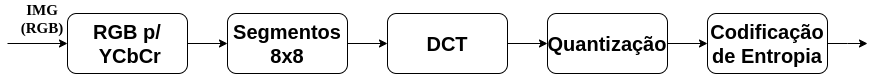

In [ ]:
# CONVERTENDO DE RGB p/ YCbCr:
img_YCrCb = RGB_to_YCrCb(img_original_rgb)
Y_nomal, Cr_nomal, Cb_nomal = cv2.split(img_YCrCb)

In [ ]:
# APLICANDO O SUB SAMPLE:

# Imagem que passou pelo sub-sampling 4:4:4
Y_444, Cr_444, Cb_444 = subSampling(img_YCrCb, '4:4:4')
# Imagem que passou pelo sub-sampling 4:2:2
Y_422, Cr_422, Cb_422 = subSampling(img_YCrCb, '4:2:2')
# Imagem que passou pelo sub-sampling 4:2:0
Y_420, Cr_420, Cb_420 = subSampling(img_YCrCb, '4:2:0')

In [ ]:
#Guardado as dimensões dos canais apos o subsampling
lum_altura,lum_largura = Y_444.shape
Crom_444_altura,Crom_444_largura = Cr_444.shape
Crom_422_altura,Crom_422_largura = Cr_422.shape
Crom_420_altura,Crom_420_largura = Cr_420.shape

In [ ]:
# Avaliando se a resolução cromatica é reduzida
print(f'Dimensões antes: Y:{Y_nomal.shape}, Cb:{Cb_nomal.shape}, Cr:{Cr_nomal.shape}\n')
print('Dimensões após a etapa sub-sample:')
print(f'[4:4:4]: Y:{Y_444.shape}, Cb:{Cb_444.shape}, Cr:{Cr_444.shape}')
print(f'[4:2:2]: Y:{Y_422.shape}, Cb:{Cb_422.shape}, Cr:{Cr_422.shape}')
print(f'[4:2:0]: Y:{Y_420.shape}, Cb:{Cb_420.shape}, Cr:{Cr_420.shape}')
print(type(Y_444[0][0]))

Dimensões antes: Y:(574, 848), Cb:(574, 848), Cr:(574, 848)

Dimensões após a etapa sub-sample:
[4:4:4]: Y:(574, 848), Cb:(574, 848), Cr:(574, 848)
[4:2:2]: Y:(574, 848), Cb:(574, 424), Cr:(574, 424)
[4:2:0]: Y:(574, 848), Cb:(287, 424), Cr:(287, 424)
<class 'numpy.uint8'>


In [ ]:
# APLICANDO A SEGMENTAÇÃO:

# Imagem que passou pelo sub-sampling 4:4:4
Y_444_8x8, altura_Y_444, largura_Y_444 = segmentacao_8x8(Y_444)
Cb_444_8x8, altura_Cb_444, largura_Cb_444 = segmentacao_8x8(Cb_444)
Cr_444_8x8, altura_Cr_444, largura_Cr_444 = segmentacao_8x8(Cr_444)

# Imagem que passou pelo sub-sampling 4:2:2
Y_422_8x8, altura_Y_422, largura_Y_422 = segmentacao_8x8(Y_422)
Cb_422_8x8, altura_Cb_422, largura_Cb_422 = segmentacao_8x8(Cb_422)
Cr_422_8x8, altura_Cr_422, largura_Cr_422 = segmentacao_8x8(Cr_422)

# Imagem que passou pelo sub-sampling 4:2:0
Y_420_8x8, altura_Y_420, largura_Y_420 = segmentacao_8x8(Y_420)
Cb_420_8x8, altura_Cb_420, largura_Cb_420 = segmentacao_8x8(Cb_420)
Cr_420_8x8, altura_Cr_420, largura_Cr_420 = segmentacao_8x8(Cr_420)

In [ ]:
print('Dimensões após a etapa segmentação:')
print(f'[4:4:4]: Y:{Y_444_8x8.shape}, Cb:{Cb_444_8x8.shape}, Cr:{Cr_444_8x8.shape}')
print(f'[4:2:2]: Y:{Y_422_8x8.shape}, Cb:{Cb_422_8x8.shape}, Cr:{Cr_422_8x8.shape}')
print(f'[4:2:0]: Y:{Y_420_8x8.shape}, Cb:{Cb_420_8x8.shape}, Cr:{Cr_420_8x8.shape}')
print(type(Y_444_8x8[0][0][0]))

Dimensões após a etapa segmentação:
[4:4:4]: Y:(7704, 8, 8), Cb:(7704, 8, 8), Cr:(7704, 8, 8)
[4:2:2]: Y:(7704, 8, 8), Cb:(3888, 8, 8), Cr:(3888, 8, 8)
[4:2:0]: Y:(7704, 8, 8), Cb:(1944, 8, 8), Cr:(1944, 8, 8)
<class 'numpy.float32'>


In [ ]:
#APLICANDO A DCT:

# Imagem que passou pelo sub-sampling 4:4:4
Y_444_dct = calcula_dct(Y_444_8x8)
Cb_444_dct = calcula_dct(Cb_444_8x8)
Cr_444_dct = calcula_dct(Cr_444_8x8)

# Imagem que passou pelo sub-sampling 4:2:2
Y_422_dct = calcula_dct(Y_422_8x8)
Cb_422_dct = calcula_dct(Cb_422_8x8)
Cr_422_dct = calcula_dct(Cr_422_8x8)

# Imagem que passou pelo sub-sampling 4:2:0
Y_420_dct = calcula_dct(Y_420_8x8)
Cb_420_dct = calcula_dct(Cb_420_8x8)
Cr_420_dct = calcula_dct(Cr_420_8x8)

In [ ]:
print('Dimensões após a etapa DCT:')
print(f'[4:4:4]: Y:{len(Y_444_dct)}, Cb:{len(Cb_444_dct)}, Cr:{len(Cr_444_dct)}')
print(f'[4:2:2]: Y:{len(Y_422_dct)}, Cb:{len(Cb_422_dct)}, Cr:{len(Cr_422_dct)}')
print(f'[4:2:0]: Y:{len(Y_420_dct)}, Cb:{len(Cb_420_dct)}, Cr:{len(Cr_420_dct)}')
print(type(Y_444_dct[0][0][0]))

Dimensões após a etapa DCT:
[4:4:4]: Y:7704, Cb:7704, Cr:7704
[4:2:2]: Y:7704, Cb:3888, Cr:3888
[4:2:0]: Y:7704, Cb:1944, Cr:1944
<class 'numpy.float32'>


In [ ]:
# APLICANDO A QUANTIZAÇÃO

# Imagem que passou pelo sub-sampling 4:4:4
Y_444_dct_quant = quantizacao(Y_444_dct, tabela_lum, "quantiza")
Cb_444_dct_quant = quantizacao(Cb_444_dct, tabela_crom, "quantiza")
Cr_444_dct_quant = quantizacao(Cr_444_dct, tabela_crom, "quantiza")

# Imagem que passou pelo sub-sampling 4:2:2
Y_422_dct_quant = quantizacao(Y_422_dct, tabela_lum, "quantiza")
Cb_422_dct_quant = quantizacao(Cb_422_dct, tabela_crom, "quantiza")
Cr_422_dct_quant = quantizacao(Cr_422_dct, tabela_crom, "quantiza")

# Imagem que passou pelo sub-sampling 4:2:0
Y_420_dct_quant = quantizacao(Y_420_dct, tabela_lum, "quantiza")
Cb_420_dct_quant = quantizacao(Cb_420_dct, tabela_crom, "quantiza")
Cr_420_dct_quant = quantizacao(Cr_420_dct, tabela_crom, "quantiza")

In [ ]:
print('Dimensões após a etapa Quantização:')
print(f'[4:4:4]: Y:{len(Y_444_dct_quant)}, Cb:{len(Cb_444_dct_quant)}, Cr:{len(Cr_444_dct_quant)}')
print(f'[4:2:2]: Y:{len(Y_422_dct_quant)}, Cb:{len(Cb_422_dct_quant)}, Cr:{len(Cr_422_dct_quant)}')
print(f'[4:2:0]: Y:{len(Y_420_dct_quant)}, Cb:{len(Cb_420_dct_quant)}, Cr:{len(Cr_420_dct_quant)}')
print(type(Y_444_dct_quant[0][0][0]))

Dimensões após a etapa Quantização:
[4:4:4]: Y:7704, Cb:7704, Cr:7704
[4:2:2]: Y:7704, Cb:3888, Cr:3888
[4:2:0]: Y:7704, Cb:1944, Cr:1944
<class 'numpy.float32'>


In [ ]:
# APLICANDO A CODIFICAÇÃO DE ENTROPIA

# Imagem que passou pelo sub-sampling 4:4:4
#codificar_entropia(Y_444_dct_quant)
#codificar_entropia(Cb_444_dct_quant)
#codificar_entropia(Cr_444_dct_quant)

# Imagem que passou pelo sub-sampling 4:2:2
#codificar_entropia(Y_444_dct_quant)
#codificar_entropia(Cb_444_dct_quant)
#codificar_entropia(Cr_444_dct_quant)

# Imagem que passou pelo sub-sampling 4:2:0
#codificar_entropia(Y_444_dct_quant)
#codificar_entropia(Cb_444_dct_quant)
#codificar_entropia(Cr_444_dct_quant)

## Aplicando as etapas de **Decodificação**

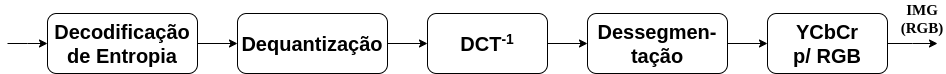

In [ ]:
# APLICANDO A DECODIFICAÇÃO DE ENTROPIA

In [ ]:
# APLICANDO A DEQUANTIZAÇÃO

# Imagem que passou pelo sub-sampling 4:4:4
Y_444_dct_dequant = quantizacao(Y_444_dct_quant, tabela_lum, "dequantiza")
Cb_444_dct_dequant = quantizacao(Cb_444_dct_quant, tabela_crom, "dequantiza")
Cr_444_dct_dequant = quantizacao(Cr_444_dct_quant, tabela_crom, "dequantiza")

# Imagem que passou pelo sub-sampling 4:2:2
Y_422_dct_dequant = quantizacao(Y_422_dct_quant, tabela_lum, "dequantiza")
Cb_422_dct_dequant = quantizacao(Cb_422_dct_quant, tabela_crom, "dequantiza")
Cr_422_dct_dequant = quantizacao(Cr_422_dct_quant, tabela_crom, "dequantiza")

# Imagem que passou pelo sub-sampling 4:2:0
Y_420_dct_dequant = quantizacao(Y_420_dct_quant, tabela_lum, "dequantiza")
Cb_420_dct_dequant = quantizacao(Cb_420_dct_quant, tabela_crom, "dequantiza")
Cr_420_dct_dequant = quantizacao(Cr_420_dct_quant, tabela_crom, "dequantiza")

In [ ]:
print('Dimensões após a etapa Dequantização:')
print(f'[4:4:4]: Y:{len(Y_444_dct_dequant)}, Cb:{len(Cb_444_dct_dequant)}, Cr:{len(Cr_444_dct_dequant)}')
print(f'[4:2:2]: Y:{len(Y_422_dct_dequant)}, Cb:{len(Cb_422_dct_dequant)}, Cr:{len(Cr_422_dct_dequant)}')
print(f'[4:2:0]: Y:{len(Y_420_dct_dequant)}, Cb:{len(Cb_420_dct_dequant)}, Cr:{len(Cr_420_dct_dequant)}')
print(type(Y_444_dct_dequant[0][0][0]))

Dimensões após a etapa Dequantização:
[4:4:4]: Y:7704, Cb:7704, Cr:7704
[4:2:2]: Y:7704, Cb:3888, Cr:3888
[4:2:0]: Y:7704, Cb:1944, Cr:1944
<class 'numpy.float32'>


In [ ]:
# APLICANDO A DCT INVERSA E A DESEGMENTAÇÃO

# Imagem que passou pelo sub-sampling 4:4:4
Y_444_idct_dequant = calcula_dct_inversa(Y_444_dct_dequant, altura_Y_444, largura_Y_444)
Cb_444_idct_dequant = calcula_dct_inversa(Cb_444_dct_dequant, altura_Cb_444, largura_Cb_444)
Cr_444_idct_dequant = calcula_dct_inversa(Cr_444_dct_dequant, altura_Cr_444, largura_Cr_444)

# Imagem que passou pelo sub-sampling 4:2:2
Y_422_idct_dequant = calcula_dct_inversa(Y_422_dct_dequant, altura_Y_422, largura_Y_422)
Cb_422_idct_dequant = calcula_dct_inversa(Cb_422_dct_dequant, altura_Cb_422, largura_Cb_422)
Cr_422_idct_dequant = calcula_dct_inversa(Cr_422_dct_dequant, altura_Cr_422, largura_Cr_422)

# Imagem que passou pelo sub-sampling 4:2:0
Y_420_idct_dequant = calcula_dct_inversa(Y_420_dct_dequant, altura_Y_420, largura_Y_420)
Cb_420_idct_dequant = calcula_dct_inversa(Cb_420_dct_dequant, altura_Cb_420, largura_Cb_420)
Cr_420_idct_dequant = calcula_dct_inversa(Cr_420_dct_dequant, altura_Cr_420, largura_Cr_420)

In [ ]:
#Retornando as dimensões dos canais
# 4:4:4
Y_444_idct_dequant = retornar_tamanho_matriz(Y_444_idct_dequant,lum_altura,lum_largura)
Cb_444_idct_dequant = retornar_tamanho_matriz(Cb_444_idct_dequant,Crom_444_altura,Crom_444_largura)
Cr_444_idct_dequant = retornar_tamanho_matriz(Cr_444_idct_dequant,Crom_444_altura,Crom_444_largura)

# 4:2:2
Y_422_idct_dequant = retornar_tamanho_matriz(Y_422_idct_dequant,lum_altura,lum_largura)
Cb_422_idct_dequant = retornar_tamanho_matriz(Cb_422_idct_dequant,Crom_422_altura,Crom_422_largura)
Cr_422_idct_dequant = retornar_tamanho_matriz(Cr_422_idct_dequant,Crom_422_altura,Crom_422_largura)

# 4:2:0
Y_420_idct_dequant = retornar_tamanho_matriz(Y_420_idct_dequant,lum_altura,lum_largura)
Cb_420_idct_dequant = retornar_tamanho_matriz(Cb_420_idct_dequant,Crom_420_altura,Crom_420_largura)
Cr_420_idct_dequant = retornar_tamanho_matriz(Cr_420_idct_dequant,Crom_420_altura,Crom_420_largura)

In [ ]:
print(Y_444_idct_dequant.dtype, Cr_444_idct_dequant.dtype, Cb_444_idct_dequant.dtype)
print(Y_422_idct_dequant.dtype, Cr_422_idct_dequant.dtype, Cb_422_idct_dequant.dtype)
print(Y_420_idct_dequant.dtype, Cr_420_idct_dequant.dtype, Cb_420_idct_dequant.dtype)

uint8 uint8 uint8
uint8 uint8 uint8
uint8 uint8 uint8


In [ ]:
# CONVERTENDO DE YCbCr p/ RGB:
# Up-sample
Y_444, Cr_444, Cb_444 = upSampling(Y_444_idct_dequant, Cr_444_idct_dequant, Cb_444_idct_dequant, '4:4:4')
Y_422, Cr_422, Cb_422 = upSampling(Y_422_idct_dequant, Cr_422_idct_dequant, Cb_422_idct_dequant, '4:2:2')
Y_420, Cr_420, Cb_420 = upSampling(Y_420_idct_dequant, Cr_420_idct_dequant, Cb_420_idct_dequant, '4:2:0')

# Avaliando se a resolução cromatica é restaurada
print(f'Dimensões antes: Y:{Y_nomal.shape}, Cb:{Cb_nomal.shape}, Cr:{Cr_nomal.shape}\n')
print('Dimensões após a etapa up-sample:')
print(f'[4:4:4]: Y:{Y_444.shape}, Cb:{Cb_444.shape}, Cr:{Cr_444.shape}')
print(f'[4:2:2]: Y:{Y_422.shape}, Cb:{Cb_422.shape}, Cr:{Cr_422.shape}')
print(f'[4:2:0]: Y:{Y_420.shape}, Cb:{Cb_420.shape}, Cr:{Cr_420.shape}')

Dimensões antes: Y:(574, 848), Cb:(574, 848), Cr:(574, 848)

Dimensões após a etapa up-sample:
[4:4:4]: Y:(574, 848), Cb:(574, 848), Cr:(574, 848)
[4:2:2]: Y:(574, 848), Cb:(574, 848), Cr:(574, 848)
[4:2:0]: Y:(574, 848), Cb:(574, 848), Cr:(574, 848)


In [ ]:
# CONVERTENDO DE YCbCr p/ RGB:

# Mesclando as conponentes
img_444_decodificada_YCbCr = cv2.merge([Y_444, Cr_444, Cb_444])
img_422_decodificada_YCbCr = cv2.merge([Y_422, Cr_422, Cb_422])
img_420_decodificada_YCbCr = cv2.merge([Y_420, Cr_420, Cb_420])

tamanho_original = (574, 848)
img_444_decodificada_YCbCr = redimensionar_matriz_para_o_tamanho_original(img_444_decodificada_YCbCr, tamanho_original)
img_422_decodificada_YCbCr = redimensionar_matriz_para_o_tamanho_original(img_422_decodificada_YCbCr, tamanho_original)
img_420_decodificada_YCbCr = redimensionar_matriz_para_o_tamanho_original(img_420_decodificada_YCbCr, tamanho_original)

# convertendo
img_444_decodificada_RGB = YCrCb_to_RGB(img_444_decodificada_YCbCr)
img_422_decodificada_RGB = YCrCb_to_RGB(img_422_decodificada_YCbCr)
img_420_decodificada_RGB = YCrCb_to_RGB(img_420_decodificada_YCbCr)

In [ ]:
print(Y_444.dtype, Cr_444.dtype, Cb_444.dtype)
print(Y_422.dtype, Cr_422.dtype, Cb_422.dtype)
print(Y_420.dtype, Cr_420.dtype, Cb_420.dtype)

uint8 uint8 uint8
uint8 uint8 uint8
uint8 uint8 uint8


## Avaliando a qualidade da restauração

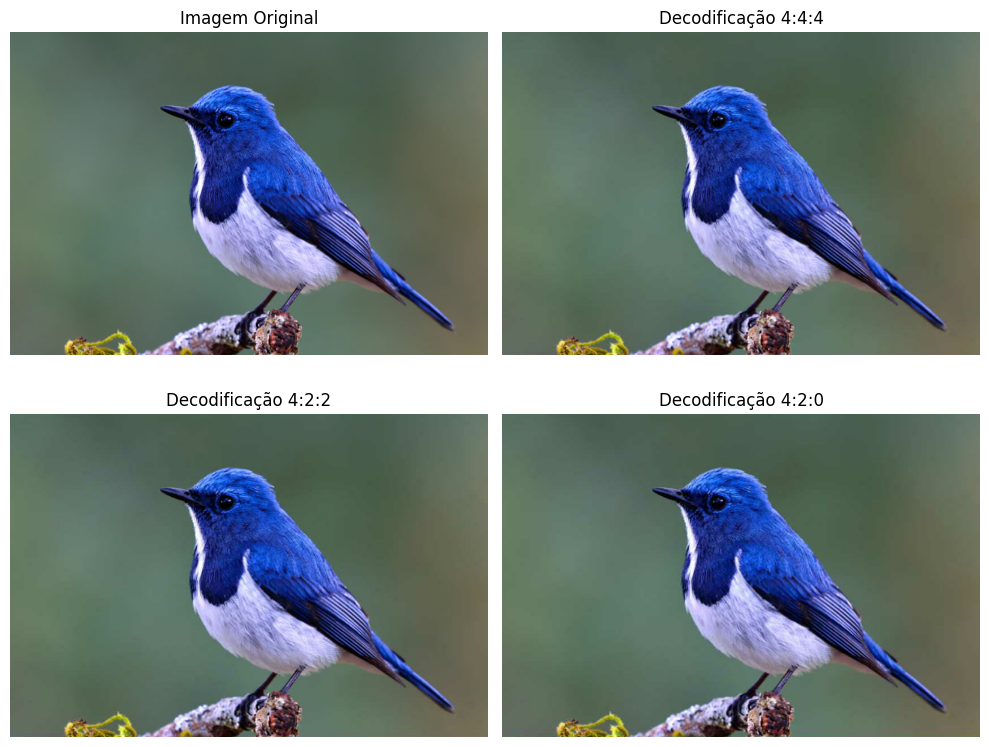

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Removendo os eixos em todas as imagens
for ax in axs.ravel():
    ax.axis('off')

# Exibindo as imagens
axs[0, 0].imshow(img_original_rgb)
axs[0, 0].set_title('Imagem Original')

axs[0, 1].imshow(img_444_decodificada_RGB)
axs[0, 1].set_title('Decodificação 4:4:4')

axs[1, 0].imshow(img_422_decodificada_RGB)
axs[1, 0].set_title('Decodificação 4:2:2')

axs[1, 1].imshow(img_420_decodificada_RGB)
axs[1, 1].set_title('Decodificação 4:2:0')

# Ajustando o espaçamento entre as subplots
plt.tight_layout()

# Exibindo a figura
plt.show()

In [ ]:
# Avaliando qualidade baseada no PSNR
print(f'IMAGENS COMPARADAS      PSNR (dB)')
print(f'Original vs Original    {calculaPSNR(img_original_rgb, img_original_rgb)}')
print(f'Original vs 4:4:4       {calculaPSNR(img_original_rgb, img_444_decodificada_RGB)}')
print(f'Original vs 4:2:2       {calculaPSNR(img_original_rgb, img_422_decodificada_RGB)}')
print(f'Original vs 4:2:0       {calculaPSNR(img_original_rgb, img_420_decodificada_RGB)}')

IMAGENS COMPARADAS      PSNR (dB)
Original vs Original    inf
Original vs 4:4:4       34.43591205322833
Original vs 4:2:2       33.723576317223234
Original vs 4:2:0       32.968864168842195


In [ ]:
print(f'Original vs Original    {cv2.PSNR(img_original_rgb,img_original_rgb)}')
print(f'Original vs 4:4:4       {cv2.PSNR(img_original_rgb,img_444_decodificada_RGB)}')
print(f'Original vs 4:2:2       {cv2.PSNR(img_original_rgb,img_422_decodificada_RGB)}')
print(f'Original vs 4:2:0       {cv2.PSNR(img_original_rgb,img_420_decodificada_RGB)}')

Original vs Original    361.20199909921956
Original vs 4:4:4       34.43591130077855
Original vs 4:2:2       33.723575080517236
Original vs 4:2:0       32.96886509675581
